# StroopActFlow
### Sanity checking data for pilot subjects
### Identify stimuli localizers for input layer for Stroop Model


#### Taku Ito
#### 1/13/2017


In [78]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as mc
import os
import nibabel as nib

In [55]:
def convertCSVToCIFTI64k(inputfilename,outputfilename):
    ciftitemplate = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
    wb_command = 'wb_command -cifti-convert -from-text' 
    wb_command += ' ' + inputfilename 
    wb_command += ' ' + ciftitemplate
    wb_command += ' ' + outputfilename
    wb_command += " -col-delim ','"
    wb_command += ' -reset-scalars'
    os.system(wb_command)
#     print wb_command

## 0.0 Set up

In [18]:
subjNums = ['101', '102']

basedir = '/projects3/StroopActFlow/data/'
resultsdir = basedir + 'results/'
restdir = resultsdir + 'glmRest_GlasserParcels/'

glasser_nets = np.loadtxt('/projects/AnalysisTools/netpartitions/ColeLabNetPartition_v1.1/community_order.txt', delimiter=',')
# Make into python numbering (starts from 0)
glasser_nets -= 1.0
networkorder = glasser_nets.astype(int)
networkorder.shape = (len(networkorder),1)

networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud1':8, 'aud2':9, 'dan':11}
networks = networkmappings.keys()

networkdef = '/projects/AnalysisTools/netpartitions/ColeLabNetPartition_v1.1/parcel_network_assignments.txt'
networkdef = np.loadtxt(networkdef, delimiter=',')
xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## 1.0 Resting-state analysis

In [10]:
restmat = {}
for subj in subjNums:
    restdat = np.loadtxt(restdir + subj + '_rest_nuisanceResids_Glasser.csv',delimiter=',')
    
    restmat[subj] = np.corrcoef(restdat)
    

### 1.1 Plot rest matrices for each subject

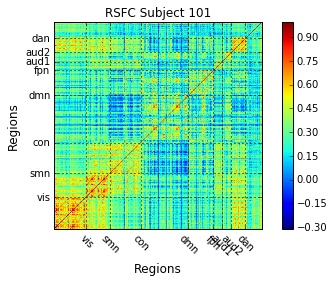

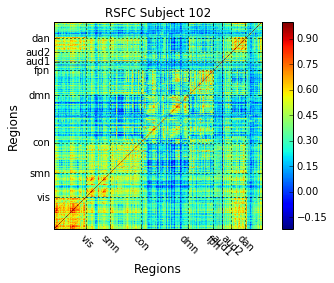

In [154]:
for subj in subjNums:
    plt.figure()
    plt.title('RSFC Subject ' + subj)
    plt.imshow(restmat[subj][networkorder,networkorder.T],origin='lower')
    plt.xlabel('Regions',fontsize=12)
    plt.ylabel('Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)
    plt.tight_layout()
    plt.colorbar()
#     plt.savefig(subj + '_RSFC_PearsonCorr.pdf')

## 2.0 Run task activation analysis on 64k Surface for four different stimuli localizers

In [108]:
def loadBetas(subj):
    datadir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
    # Load smoothed betas!
    betas = np.loadtxt(datadir + subj + '_neutralStimuliByTrial_taskBetas_Surface64k_sm.csv',delimiter=',')
    betas = betas[:,18:] # 18 onwards are the two task betas
    return betas

In [109]:
def loadBetasFromDscalar(subj):
    datadir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
    # Load smoothed betas!
    betas = nib.load(datadir + subj + '_neutralStimuliByTrial_taskBetas_Surface64k_sm.dscalar.nii')
    betas = betas.get_data()
    betas = np.squeeze(betas)
    betas = betas.T
    betas = betas[:,18:] # 18 onwards are the two task betas
    return betas

### 2.0.1 Convert CSV to Dscalar and then run smoothing on beta maps

* Smoothing with 4mm FWHM on surface

In [156]:
for subj in subjNums:
    print 'Subject', subj
    basedir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
    
    print 'Converting CSV to dscalar...'
    csvfile = basedir + subj + '_neutralStimuliByTrial_taskBetas_Surface64k.csv'
    dscalarfile = basedir + subj + '_neutralStimuliByTrial_taskBetas_Surface64k.dscalar.nii'
    convertCSVToCIFTI64k(csvfile, dscalarfile)
    
    print 'Smoothing surface files...'
    dscalar_sm_file = basedir + subj + '_neutralStimuliByTrial_taskBetas_Surface64k_sm.dscalar.nii'
    subjdir = '/projects3/StroopActFlow/data/' + subj + '/MNINonLinear/fsaverage_LR32k/'
    lsurf = subjdir + subj + '.L.inflated.32k_fs_LR.surf.gii'
    rsurf = subjdir + subj + '.R.inflated.32k_fs_LR.surf.gii'
    
    wb_command = 'wb_command -cifti-smoothing ' + dscalarfile + ' 4 4 COLUMN ' + dscalar_sm_file
    wb_command += ' -left-surface ' + lsurf
    wb_command += ' -right-surface ' + rsurf
    os.system(wb_command)

Subject 101
Converting CSV to dscalar...
Smoothing surface files...
Subject 102
Converting CSV to dscalar...
Smoothing surface files...


### 2.1 Run statistical analysis (i.e., activation threshold analysis) against 0
* Stim 1: Neutral Color Green
* Stim 2: Neutral Color Red
* Stim 3: Neutral Word Green
* Stim 4: Neutral Word Red

Betas are z-scored prior to running t-tests against 0

In [130]:
ntrials_perstim = 45
nstims = 4

tmat = {}
pmat = {}
qmat = {}
tmat_fdr = {}

for subj in subjNums:
    print 'Running within-subject analysis on subj', subj
    
    betas = loadBetasFromDscalar(subj)
    betas = stats.zscore(betas,axis=0)
    tmat[subj] = np.zeros((betas.shape[0],nstims))
    pmat[subj] = np.zeros((betas.shape[0],nstims))
    qmat[subj] = np.zeros((betas.shape[0],nstims))
    tmat_fdr[subj] = np.zeros((betas.shape[0],nstims + 1)) # Include conjunction
    
    i=0
    for stim in range(nstims):
        print 'Thresholding statistical maps for stim', stim
        beta_mat = np.zeros((betas.shape[0],ntrials_perstim))
        for trial in range(ntrials_perstim):
            beta_mat[:,trial] = betas[:,i]
            i += 1
            
        
        
        # Run t-test
        t = []
        p = []
        for vertex in range(beta_mat.shape[0]):
            t, p = stats.ttest_1samp(beta_mat[vertex,:],0)
            
            # Make one-sided t-test
            if t > 0:
                p = p/2.0
            else:
                p = 1.0 - p/2.0
                
            tmat[subj][vertex,stim] = t
            pmat[subj][vertex,stim] = p
            

            
        # Run FDR correction
        h0, qmat[subj][:,stim] = mc.fdrcorrection0(pmat[subj][:,stim])
        # Threshold tmat for significance
        tmat_fdr[subj][:,stim] = np.multiply(h0,tmat[subj][:,stim]) 
        # Include conjunction map
        tmat_fdr[subj][:,4] = tmat_fdr[subj][:,4] + h0
        
    tmat_fdr[subj][:,4] = tmat_fdr[subj][:,4] == nstims
        
        

Running within-subject analysis on subj 101
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1
Thresholding statistical maps for stim 2
Thresholding statistical maps for stim 3
Running within-subject analysis on subj 102
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1
Thresholding statistical maps for stim 2
Thresholding statistical maps for stim 3


#### Save to CSV

In [131]:
basedir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_neutralStimuliByTrial_tstats.csv'
    filename_tmatfdr = basedir + subj + '_neutralStimuliByTrial_tstatsThresh.csv'
        
    np.savetxt(filename_tmat, tmat[subj], delimiter=',')
    np.savetxt(filename_tmatfdr, tmat_fdr[subj], delimiter=',')

#### Convert statistical maps to surface maps

In [132]:
basedir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_neutralStimuliByTrial_tstats.csv'
    filename_tmatfdr = basedir + subj + '_neutralStimuliByTrial_tstatsThresh.csv'
    
    cifti_tmat = basedir + subj + '_neutralStimuliByTrial_tstats.dscalar.nii'
    cifti_tmatfdr = basedir + subj + '_neutralStimuliByTrial_tstatsThresh.dscalar.nii'
    
    convertCSVToCIFTI64k(filename_tmat, cifti_tmat)
    convertCSVToCIFTI64k(filename_tmatfdr, cifti_tmatfdr)

## 2.2 Run statistical analysis (i.e., activation threshold analysis) with contrasts against other stimulus conditions

In [150]:
ntrials_perstim = 45
nstims = 4

tmat = {}
pmat = {}
qmat = {}
tmat_fdr = {}

for subj in subjNums:
    print 'Running within-subject analysis on subj', subj
    
    betas = loadBetasFromDscalar(subj)
    betas = stats.zscore(betas,axis=0)    
    tmat[subj] = np.zeros((betas.shape[0],nstims))
    pmat[subj] = np.zeros((betas.shape[0],nstims))
    qmat[subj] = np.zeros((betas.shape[0],nstims))
    tmat_fdr[subj] = np.zeros((betas.shape[0],nstims))
    
    # Construct index for which stims corresopnd to which columns
    stim_ind = np.arange(4,dtype=np.ndarray)
    stim_ind.shape = (stim_ind.shape[0],1)
    stim_ind = np.reshape(np.tile(a,ntrials_perstim),-1)
    for stim in range(nstims):
        print 'Thresholding statistical maps for stim', stim
        beta_mat = np.zeros((betas.shape[0],ntrials_perstim))
        beta_mat_contrast = np.zeros((betas.shape[0],ntrials_perstim*(nstims-1)))
                          
        cond_ind = np.where(stim_ind==stim)[0]
        beta_mat[:,:] = betas[:,cond_ind]
        
        notcond_ind = np.where(stim_ind!=stim)[0]
        beta_mat_contrast[:,:] = betas[:,notcond_ind]        
        
        # Run t-test
        t = []
        p = []
        for vertex in range(beta_mat.shape[0]):
            t, p = stats.ttest_ind(beta_mat[vertex,:],beta_mat_contrast[vertex,:])
            
            # Make one-sided t-test
            if t > 0:
                p = p/2.0
            else:
                p = 1.0 - p/2.0
                
            tmat[subj][vertex,stim] = t
            pmat[subj][vertex,stim] = p
            

            
        # Run FDR correction
        h0, qmat[subj][:,stim] = mc.fdrcorrection0(pmat[subj][:,stim])
        # Threshold tmat for significance
        tmat_fdr[subj][:,stim] = np.multiply(h0,tmat[subj][:,stim]) 
        
        

Running within-subject analysis on subj 101
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1
Thresholding statistical maps for stim 2
Thresholding statistical maps for stim 3
Running within-subject analysis on subj 102
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1
Thresholding statistical maps for stim 2
Thresholding statistical maps for stim 3


#### Save to CSV

In [151]:
basedir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_neutralStimuliByTrial_tstats_StimVAll.csv'
    filename_tmatfdr = basedir + subj + '_neutralStimuliByTrial_tstatsThresh_StimVAll.csv'
        
    np.savetxt(filename_tmat, tmat[subj], delimiter=',')
    np.savetxt(filename_tmatfdr, tmat_fdr[subj], delimiter=',')

## Convert statistical maps to surface maps

In [153]:
basedir = '/projects3/StroopActFlow/data/results/glm_neutral_stimuli/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_neutralStimuliByTrial_tstats_StimVAll.csv'
    filename_tmatfdr = basedir + subj + '_neutralStimuliByTrial_tstatsThresh_StimVAll.csv'
    
    cifti_tmat = basedir + subj + '_neutralStimuliByTrial_tstats_StimVAll.dscalar.nii'
    cifti_tmatfdr = basedir + subj + '_neutralStimuliByTrial_tstatsThresh_StimVAll.dscalar.nii'
    
    convertCSVToCIFTI64k(filename_tmat, cifti_tmat)
    convertCSVToCIFTI64k(filename_tmatfdr, cifti_tmatfdr)

___

## 3.0 Run task-rule encoding against 0
### Isolate top-down control (i.e., hypothesized PFC)

In [157]:
def loadBetasFromDscalarTaskRuleEncoding(subj):
    datadir = '/projects3/StroopActFlow/data/results/glm_taskruleencoding/'
    # Load smoothed betas!
    betas = nib.load(datadir + subj + '_taskRuleEncoding_taskBetas_Surface64k_sm.dscalar.nii')
    betas = betas.get_data()
    betas = np.squeeze(betas)
    betas = betas.T
    betas = betas[:,18:] # 18 onwards are the two task betas
    return betas

In [167]:
for subj in subjNums:
    print 'Subject', subj
    glmdir = '/projects3/StroopActFlow/data/results/glm_taskruleencoding/' 
    
    print 'Converting CSV to dscalar...'
    csvfile = glmdir + subj + '_taskruleEncoding_taskBetas_Surface64k.csv'
    dscalarfile = glmdir + subj + '_taskRuleEncoding_taskBetas_Surface64k.dscalar.nii'
    convertCSVToCIFTI64k(csvfile, dscalarfile)
    
    print 'Smoothing surface files...'
    dscalar_sm_file = glmdir + subj + '_taskRuleEncoding_taskBetas_Surface64k_sm.dscalar.nii'
    subjdir = '/projects3/StroopActFlow/data/' + subj + '/MNINonLinear/fsaverage_LR32k/'
    lsurf = subjdir + subj + '.L.inflated.32k_fs_LR.surf.gii'
    rsurf = subjdir + subj + '.R.inflated.32k_fs_LR.surf.gii'
    
    wb_command = 'wb_command -cifti-smoothing ' + dscalarfile + ' 4 4 COLUMN ' + dscalar_sm_file
    wb_command += ' -left-surface ' + lsurf
    wb_command += ' -right-surface ' + rsurf
    os.system(wb_command)

Subject 101
Converting CSV to dscalar...
Smoothing surface files...
Subject 102
Converting CSV to dscalar...
Smoothing surface files...


### 3.0.1 Run statistical analysis (i.e., activation threshold analysis) against 0
* Task 1: ColorEncoding
* Task 2: WordEncoding

Betas are z-scored prior to running t-tests against 0

In [191]:
ntrials_perstim = 30
nstims = 2

tmat = {}
pmat = {}
qmat = {}
tmat_fdr = {}

for subj in subjNums:
    print 'Running within-subject analysis on subj', subj
    
    betas = loadBetasFromDscalarTaskRuleEncoding(subj)
    betas = stats.zscore(betas,axis=0)
    tmat[subj] = np.zeros((betas.shape[0],nstims))
    pmat[subj] = np.zeros((betas.shape[0],nstims))
    qmat[subj] = np.zeros((betas.shape[0],nstims))
    tmat_fdr[subj] = np.zeros((betas.shape[0],nstims + 1)) # Include conjunction
    
    # Construct index for which stims corresopnd to which columns
    stim_ind = np.arange(nstims,dtype=np.ndarray)
    stim_ind.shape = (stim_ind.shape[0],1)
    stim_ind = np.reshape(np.tile(stim_ind,ntrials_perstim),-1)
    for stim in range(nstims):
        print 'Thresholding statistical maps for stim', stim
        beta_mat = np.zeros((betas.shape[0],ntrials_perstim))
                          
        cond_ind = np.where(stim_ind==stim)[0]
        beta_mat[:,:] = betas[:,cond_ind]
            
        # Run t-test
        t = []
        p = []
        for vertex in range(beta_mat.shape[0]):
            t, p = stats.ttest_1samp(beta_mat[vertex,:],0)
            
            # Make one-sided t-test
            if t > 0:
                p = p/2.0
            else:
                p = 1.0 - p/2.0
                
            tmat[subj][vertex,stim] = t
            pmat[subj][vertex,stim] = p
            

            
        # Run FDR correction
        h0, qmat[subj][:,stim] = mc.fdrcorrection0(pmat[subj][:,stim])
        # Threshold tmat for significance
        tmat_fdr[subj][:,stim] = np.multiply(h0,tmat[subj][:,stim])         
        # Include conjunction map
        tmat_fdr[subj][:,2] = tmat_fdr[subj][:,2] + h0
        
    tmat_fdr[subj][:,2] = tmat_fdr[subj][:,2] == nstims

Running within-subject analysis on subj 101
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1
Running within-subject analysis on subj 102
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1


#### Save to CSV

In [192]:
basedir = '/projects3/StroopActFlow/data/results/glm_taskruleencoding/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_taskRuleEncoding_tstats.csv'
    filename_tmatfdr = basedir + subj + '_taskRuleEncoding_tstatsThresh.csv'
        
    np.savetxt(filename_tmat, tmat[subj], delimiter=',')
    np.savetxt(filename_tmatfdr, tmat_fdr[subj], delimiter=',')

#### Convert statistical maps to surface maps

In [193]:
basedir = '/projects3/StroopActFlow/data/results/glm_taskruleencoding/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_taskRuleEncoding_tstats.csv'
    filename_tmatfdr = basedir + subj + '_taskRuleEncoding_tstatsThresh.csv'
    
    cifti_tmat = basedir + subj + '_taskRuleEncoding_tstats.dscalar.nii'
    cifti_tmatfdr = basedir + subj + '_taskRuleEncoding_tstatsThresh.dscalar.nii'
    
    convertCSVToCIFTI64k(filename_tmat, cifti_tmat)
    convertCSVToCIFTI64k(filename_tmatfdr, cifti_tmatfdr)

## 3.1 Run task-rule encoding contrasts (color v. word)
### Isolate top-down control (i.e., hypothesized PFC)

### 3.1.1 Run statistical analysis (i.e., activation threshold analysis) against 0
* Task 1: ColorEncoding
* Task 2: WordEncoding

Betas are z-scored prior to running t-tests against 0

In [186]:
ntrials_perstim = 30
nstims = 2

tmat = {}
pmat = {}
qmat = {}
tmat_fdr = {}

for subj in subjNums:
    print 'Running within-subject analysis on subj', subj
    
    betas = loadBetasFromDscalarTaskRuleEncoding(subj)
    betas = stats.zscore(betas,axis=0)
    tmat[subj] = np.zeros((betas.shape[0],nstims))
    pmat[subj] = np.zeros((betas.shape[0],nstims))
    qmat[subj] = np.zeros((betas.shape[0],nstims))
    tmat_fdr[subj] = np.zeros((betas.shape[0],nstims)) # Include conjunction
    
    # Construct index for which stims corresopnd to which columns
    stim_ind = np.arange(nstims,dtype=np.ndarray)
    stim_ind.shape = (stim_ind.shape[0],1)
    stim_ind = np.reshape(np.tile(stim_ind,ntrials_perstim),-1)
    for stim in range(nstims):
        print 'Thresholding statistical maps for stim', stim
        beta_mat = np.zeros((betas.shape[0],ntrials_perstim))
        beta_mat_contrast = np.zeros((betas.shape[0],ntrials_perstim*(nstims-1)))
                          
        cond_ind = np.where(stim_ind==stim)[0]
        beta_mat[:,:] = betas[:,cond_ind]
      
        notcond_ind = np.where(stim_ind!=stim)[0]
        beta_mat_contrast[:,:] = betas[:,notcond_ind]        
      
        # Run t-test
        t = []
        p = []
        for vertex in range(beta_mat.shape[0]):
            t, p = stats.ttest_rel(beta_mat[vertex,:],beta_mat_contrast[vertex,:])
            
            # Make one-sided t-test
            if t > 0:
                p = p/2.0
            else:
                p = 1.0 - p/2.0
                
            tmat[subj][vertex,stim] = t
            pmat[subj][vertex,stim] = p
            

            
        # Run FDR correction
        h0, qmat[subj][:,stim] = mc.fdrcorrection0(pmat[subj][:,stim])
        # Threshold tmat for significance
        tmat_fdr[subj][:,stim] = np.multiply(h0,tmat[subj][:,stim])         
        

Running within-subject analysis on subj 101
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1
Running within-subject analysis on subj 102
Thresholding statistical maps for stim 0
Thresholding statistical maps for stim 1


#### Save to CSV

In [189]:
basedir = '/projects3/StroopActFlow/data/results/glm_taskruleencoding/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_taskRuleEncoding_ruleContrast_tstats.csv'
    filename_tmatfdr = basedir + subj + '_taskRuleEncoding_ruleContrast_tstatsThresh.csv'
        
    np.savetxt(filename_tmat, tmat[subj], delimiter=',')
    np.savetxt(filename_tmatfdr, tmat_fdr[subj], delimiter=',')

#### Convert statistical maps to surface maps

In [190]:
basedir = '/projects3/StroopActFlow/data/results/glm_taskruleencoding/'
for subj in subjNums:
    
    filename_tmat = basedir + subj + '_taskRuleEncoding_ruleContrast_tstats.csv'
    filename_tmatfdr = basedir + subj + '_taskRuleEncoding_ruleContrast_tstatsThresh.csv'
    
    cifti_tmat = basedir + subj + '_taskRuleEncoding_ruleContrast_tstats.dscalar.nii'
    cifti_tmatfdr = basedir + subj + '_taskRuleEncoding_ruleContrast_tstatsThresh.dscalar.nii'
    
    convertCSVToCIFTI64k(filename_tmat, cifti_tmat)
    convertCSVToCIFTI64k(filename_tmatfdr, cifti_tmatfdr)

### Results 

* No significant voxels for word v. color rule contrasts (within subject)